In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os


surrogate_path = '../surrogate/routes_short_2023-06-18|14:50:15/'

In [11]:
scenario_header = ["cloudiness",
                   "precipitation",
                   "precipitation_deposits",
                   "wind_intensity",
                   "sun_azimuth_angle",
                   "sun_altitude_angle",
                   "fog_density",
                   "wetness",
                   "fog_falloff",
                   "vehicle_infront", 
                   "vehicle_opposite", 
                   "vehicle_side",
                   "start_offset",
                   "end_offset"]
surrogate_scenarios = pd.read_csv(surrogate_path+'scenario.csv',names=scenario_header)
surrogate_criterion = pd.read_csv(surrogate_path+'criterion.csv',names= ['OutsideRouteLanesTest','CollisionTest','RouteCompletionTest'])
surrogate_frontier_scenarios = np.load(surrogate_path+'output.npz')['arr_0']
surrogate_frontier_criterion = np.load(surrogate_path+'output.npz')['arr_1']

print(surrogate_scenarios.shape)
print(surrogate_criterion.shape)
print(surrogate_frontier_scenarios.shape)
print(surrogate_frontier_criterion.shape)

(15040, 14)
(15040, 3)
(50, 14)
(50, 3)


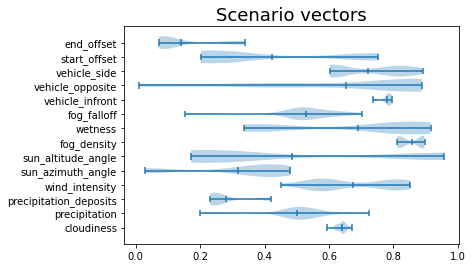

In [12]:
plt.violinplot(surrogate_frontier_scenarios, vert=False, showmeans=True, widths=0.9)
plt.yticks(range(1,15), scenario_header)
plt.title("Scenario vectors", fontsize=18)
plt.show()

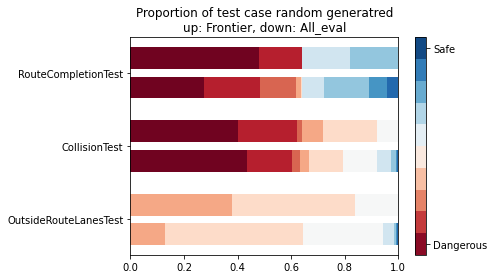

In [29]:
import matplotlib as mpl
import matplotlib.pyplot as plt

cmap = mpl.cm.RdBu
colors = cmap(range(3,253,25))

stack_hist_continuous = np.concatenate([
    [np.histogram(surrogate_frontier_criterion[:,0], range=(0,1), bins=10)[0]/surrogate_frontier_criterion.shape[0]],
    [np.histogram(surrogate_frontier_criterion[:,1], range=(0,1), bins=10)[0]/surrogate_frontier_criterion.shape[0]],
    [np.histogram(surrogate_frontier_criterion[:,2], range=(0,1), bins=10)[0]/surrogate_frontier_criterion.shape[0]],
])

left = np.zeros(3)
for i in range(10):
    plt.barh(y = np.arange(3)+0.2, width = stack_hist_continuous[:,i], left=left, color = colors[i], height=0.3)
    left += stack_hist_continuous[:,i]

stack_hist_continuous = np.concatenate([
    [np.histogram(surrogate_criterion['OutsideRouteLanesTest'], range=(0,1), bins=10)[0]/surrogate_criterion.shape[0]],
    [np.histogram(surrogate_criterion['CollisionTest'],         range=(0,1), bins=10)[0]/surrogate_criterion.shape[0]],
    [np.histogram(surrogate_criterion['RouteCompletionTest'],   range=(0,1), bins=10)[0]/surrogate_criterion.shape[0]],
])

left = np.zeros(3)
for i in range(10):
    plt.barh(y = np.arange(3)-0.2, width = stack_hist_continuous[:,i], left=left, color = colors[i], height=0.3)
    left += stack_hist_continuous[:,i]

plt.yticks(range(3), ['OutsideRouteLanesTest','CollisionTest','RouteCompletionTest'])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=cmap), ticklocation='right',values=range(10), ticks=[0, 9])
cbar.ax.set_yticklabels(['Dangerous', 'Safe'])  # vertically oriented colorbar

plt.title('Proportion of test case random generatred\nup: Frontier, down: All_eval')
plt.show()

Pymoo checkpoint

In [3]:
import joblib
import dill
import numpy as np

from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.termination import get_termination
from pymoo.termination.max_gen import MaximumGenerationTermination


In [4]:
class SurrogateProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(n_var=14,
                         n_obj=3,
                         xl=np.zeros(14),
                         xu=np.ones(14))
        

    def _evaluate(self, x, out, *args, **kwargs):
        # model_path = './tools/models/'
        model_path = '../tools/models/regression-HGB'
        surrogate_models = {"RouteCompletionTest"  : joblib.load(model_path+'-RouteCompletionTest.pkl'), 
                            "CollisionTest"        : joblib.load(model_path+'-CollisionTest.pkl'), 
                            "OutsideRouteLanesTest": joblib.load(model_path+'-OutsideRouteLanesTest.pkl'), 
                            "Timeout"              : joblib.load(model_path+'-Timeout.pkl')}
        result = np.array([
            surrogate_models["OutsideRouteLanesTest"].predict([x])[0],
            surrogate_models["CollisionTest"].predict([x])[0],
            surrogate_models["RouteCompletionTest"].predict([x])[0]
        ])
        result[result>1] = 1
        result[result<0] = 0

        out['F'] = result

In [11]:
pop_size = 2
n_offsprings = 2
generations = 2

problem = SurrogateProblem()
algorithm = NSGA2(
    pop_size=pop_size,
    n_offsprings=n_offsprings,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True,
    seed=1,
    copy_algorithm=False,
    # save_history=True,
    verbose=True
)

# algorithm.setup(problem, seed=1, termination=('n_gen', generations))

# i = 0
# save_step = 5
# while algorithm.has_next():
#     algorithm.next()
#     print(algorithm.n_gen)
#     if i % save_step == save_step:
#         with open("./ckpt/checkpoint-{}.ckpt".format(i), "wb") as f:
#             dill.dump(algorithm, f)
#     i += 1



In [12]:
# termination = get_termination("n_gen", 5)

res = minimize(problem,
    algorithm,
     ('n_gen', generations),
    seed=1,
    copy_algorithm=False,
    # save_history=True,
    verbose=True
)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |        2 |      1 |             - |             -
     2 |        4 |      2 |  1.0000000000 |         ideal
     3 |        6 |      2 |  0.9456398965 |         ideal
     4 |        8 |      2 |  1.0000000000 |         ideal
     5 |       10 |      1 |  0.0063884049 |         ideal


In [13]:
with open("./ckpt/checkpoint-0.ckpt", "wb") as f:
    dill.dump(algorithm, f)

In [15]:
with open("./ckpt/checkpoint-{}.ckpt".format(0), 'rb') as f:
    checkpoint = dill.load(f)
    print("Loaded Checkpoint:", checkpoint)

# checkpoint.termination = get_termination("n_gen", 5)

# res = minimize(problem,
#     checkpoint,
#     seed=1,
#     copy_algorithm=False,
#     save_history=True,
#     verbose=True
# )

# res = minimize(problem,
#                checkpoint,
#                ("n_gen", 5),
#                seed=1,
#                copy_algorithm=False,
#                verbose=True)

Loaded Checkpoint: <pymoo.algorithms.moo.nsga2.NSGA2 object at 0x7fdd80b62310>


In [18]:
checkpoint.result().X

array([[0.03142452, 0.58365418, 0.4173048 , 0.55868983, 0.14038694,
        0.19810149, 0.80074457, 0.92562873, 0.36994726, 0.69232262,
        0.83017517, 0.89460666, 0.08504421, 0.03905478]])

In [9]:
for i in range(1, 2):

    checkpoint = None

    with open("./ckpt/checkpoint-{}.ckpt".format(i-1), 'rb') as f:
        checkpoint = dill.load(f)
        print("Loaded Checkpoint:", checkpoint)

    checkpoint.termination = MaximumGenerationTermination(5)

    res = minimize(problem,
        checkpoint,
        ('n_gen', 5),
        seed=1,
        copy_algorithm=False,
        save_history=True,
        verbose=True
    )

    with open("./ckpt/checkpoint-{}.ckpt".format(i), "wb") as f:
        dill.dump(algorithm, f)


Loaded Checkpoint: <pymoo.algorithms.moo.nsga2.NSGA2 object at 0x7f5854afc290>
     6 |      100 |     10 |  0.0509169280 |             f
Loaded Checkpoint: <pymoo.algorithms.moo.nsga2.NSGA2 object at 0x7f585535e690>
     6 |      100 |     10 |  0.0030391276 |         ideal
Loaded Checkpoint: <pymoo.algorithms.moo.nsga2.NSGA2 object at 0x7f58557b11d0>
     6 |      100 |     12 |  0.2911493876 |         nadir
Loaded Checkpoint: <pymoo.algorithms.moo.nsga2.NSGA2 object at 0x7f585522d390>
     6 |      100 |     11 |  0.0825634045 |             f
Loaded Checkpoint: <pymoo.algorithms.moo.nsga2.NSGA2 object at 0x7f5854cd8a10>
     6 |      100 |     11 |  0.0281538760 |             f
Loaded Checkpoint: <pymoo.algorithms.moo.nsga2.NSGA2 object at 0x7f58556f4c50>
     6 |      100 |     11 |  0.0477638699 |         ideal
Loaded Checkpoint: <pymoo.algorithms.moo.nsga2.NSGA2 object at 0x7f58558370d0>
     6 |      100 |     11 |  0.0431634099 |             f
Loaded Checkpoint: <pymoo.algorith

KeyboardInterrupt: 

In [21]:
import dill
from pymoo.problems import get_problem

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.optimize import minimize
from pymoo.termination.max_gen import MaximumGenerationTermination

problem = get_problem("zdt1", n_var=5)

algorithm = NSGA2(pop_size=100)

res = minimize(problem,
               algorithm,
               ('n_gen', 5),
               seed=1,
               copy_algorithm=False,
               verbose=True)

with open("checkpoint", "wb") as f:
    dill.dump(algorithm, f)

with open("checkpoint", 'rb') as f:
    checkpoint = dill.load(f)
    print("Loaded Checkpoint:", checkpoint)

# only necessary if for the checkpoint the termination criterion has been met
checkpoint.termination = MaximumGenerationTermination(20)

res = minimize(problem,
               checkpoint,
               seed=1,
               copy_algorithm=False,
               verbose=True)

ValueError: operands could not be broadcast together with shapes (2,) (3,) 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [11]:
data = [17.68278205149559, 8.202239617386182, 2.878211618426235, 0.5602352402521632, 0.4522307096529685, 0.7992644058060776, 0.8311818847236786, 0.732133982750662, 0.5934859397450452, 0.45787607276738246, 0.3413911713308973, 0.24852505894502722, 0.17770085716178355, 0.12518546617637216, 0.08722017993213084, 0.06008940110877025, 0.041160034396843126, 0.061437484304842645, 0.00679408767471176, 0.0013108802949560773, 0.004355030374239551, 0.0050236763636404835, 0.004549560144169532, 0.0037836465973792818, 0.0029475917789239295, 0.007738250759490787, 0.0026654611348057456, 6.490973289250614e-05, 0.00030934062954200405, 0.00047295078853206167, 0.00043292025148065173, 0.00036922509281363594, 0.0003253436737271854, 0.00021932655918983172, 0.00035595483911563463, 2.755299292121962e-05, 1.1543134739797612e-05, 5.955441164788578e-05, 4.4634680203313284e-05, 2.938434553694296e-05, 2.4067521065817923e-05, 5.419088739049863e-05, 4.224590838897845e-05, 2.2366983426851376e-05, 2.0037767039825103e-05, 2.4434124287219256e-05, 1.4876936170519657e-05, 3.904321919533373e-06, 1.0507875175361505e-05, 4.419268186382577e-06, 0.0003303020481583358, 0.00033016106445249676, 1.2494973010192135e-05, 1.1652712902018136e-05, 5.281127505937737e-06, 1.7509847637712544e-05, 9.708970362805547e-06, 3.4766043523946733e-06, 3.221019774528178e-05, 6.860381497965523e-06, 4.600175083558023e-06, 5.398977622522025e-06, 3.705810555247299e-05, 9.550717429365697e-06, 4.119234208086332e-06, 1.6378072322531868e-06, 3.587193790075775e-05, 1.6439359255937556e-05, 1.6268946485552037e-05, 1.0697576284672757e-05, 3.531688735391994e-05, 6.455646981561966e-06, 6.628539122122735e-06, 2.9288597227222635e-06, 3.724636809732976e-06, 0.0003332395690831192, 0.0003317067629192133, 5.351166487485743e-06, 1.1694617334628971e-05, 1.2355538094636499e-05, 6.41460669490226e-06, 2.3281829212014916e-06, 4.987101490951132e-06, 2.9664686037733652e-06, 0.4088925105120594, 0.40819548070354905, 0.0005855573333120749, 0.00027091302032151114, 0.00015129108774834533, 0.00016276230328343764, 5.9004814814887437e-05, 0.18359248322176358, 1.057216781066103, 0.24932865534588616, 0.03691566786938175, 0.014384261249197774, 1.5063514468059649, 1.9424890068520133, 2.0391862895821427, 2.061931366142884, 1.9450602117034905, 2.165247729346983, 4.47560880383923, 4.043433321043635, 4.479262157496565, 3.1066094074596413, 2.3598213848399827, 0.6798344846229487, 5.129669417810285, 11.736138112469366, 2.697464001070253, 5.744730556911953, 8.48159118441836, 5.0633019085313276, 8.409110207642282, 3.935916675003375, 3.947826809159943, 2.1392605802508977, 3.274360864089974, 2.7145520074508958, 4.810089460193868, 3.3748653194835114, 0.0055770049063555574, 0.0019312318597073496, 0.0003655865909516163, 0.00026706436721907596, 0.0004089695063407005, 0.00042001616865262924, 0.00042581013228038217, 0.0005633398132088406, 0.00012305659633685492, 0.833517799147982, 0.23550173455073553, 0.031177434506911888, 0.05180740448807755, 0.4186014371033531, 0.9928135751404845, 0.0014901055704946242, 0.0004966645719540547, 0.00031540891984471725, 0.00020706946066085795, 0.00011013142674207749, 6.133043089966454e-05, 4.7618028900865917e-05, 0.0001472885760111244, 7.49879196605703e-05, 3.73516930022352e-05, 0.00022759077133530938, 0.00023509694141038366, 1.1351971512893242, 1.133011160407664, 1.2199995077088353, 2.2548792905264916, 2.1555556525568047, 5.55672185480956, 0.07133364283833543, 1.9812426104884717, 1.9833234561525808, 0.0024433070949600967, 0.000717008079186692, 0.00023578747821887503, 0.00013120069017361367, 0.00023661902106450488, 0.0004135038372539143, 1.182941593024968, 0.1830937550131022, 2.4826749981485126, 2.7738638269792033, 2.3001779417921133, 1.5705826537962961, 1.4831123813742515, 2.656599567261497, 6.00171023158995, 5.143108666823049, 4.168221318556472, 3.5598672690373045, 3.1667691514844813, 2.9116005159562386, 2.742164725309981, 2.631076899937922, 2.3903083691532006, 2.0238244439196853, 1.7396664876162753, 1.5108322010807633, 1.3044442721192844, 1.1433721147187597, 1.00835564128003, 0.9317315722203809, 0.15296561618577906, 1.5000526664144254, 3.3508607847038943, 4.7526991750200285, 5.29132941974263, 5.614949117125072, 5.825815073655259, 11.423063595116364, 11.653612432544852, 7.6761452987445296, 0.07381209687715562, 0.004733011840255669, 0.000621030514174778, 0.0023797461280819963, 0.0027072975845791724, 0.002479910133748035, 0.002004366410825457, 0.0062661969515458, 0.002838737848190368, 4.96922745257499e-05, 0.0003631216733963642, 0.0004363155075272946, 0.0003963249851047641, 0.00032851304138830923, 1.1541600614032446, 1.00621815164743, 2.15593328398461, 1.7173949014475238, 3.2817175213081025, 1.8618795154553651, 6.792970555850316, 0.06650008557047664, 0.0041201655779052986, 0.0015793227812103355, 0.0005055948148852628, 0.0003045052975650221, 0.00017011269481032067, 0.0001906951745993444, 0.0010867565478025556, 0.0006861940195634411, 0.00011674490339522658, 5.579491094435959e-05, 0.00010894140134786186, 8.544245697962993e-05, 0.00019776646511979824, 0.00011579040524740737, 5.005482001560332e-05, 6.589306873785745e-05, 5.6215566719836006e-05, 1.525492545699978e-05, 0.00023537764264365934, 9.338829559575466e-06, 1.981434632078692e-05, 4.1260171048181025e-05, 3.8567141667944166e-05, 1.7060734715947687e-05, 7.151086859117575e-06, 2.9975763738860684e-05, 3.4161405760268052e-06, 2.4490651741082006e-05, 2.7681225443996873e-05, 2.585269716277228e-05, 1.110532084982181e-05, 0.0003539857251887573, 0.0003515051605207255, 1.4018775374916622e-05, 7.114367546313235e-06, 2.4951919479339372e-06, 4.967450071203265e-06, 1.2434306311337348e-05, 6.112404299235594e-06, 3.052159193074539e-05, 1.3066849822677034e-05, 2.124103626491114e-05, 4.7449432719864715e-06, 2.1693034562848006e-05, 6.4873973035952685e-06, 4.230859404611505e-06, 3.871377747445448e-06, 1.3826789477504219e-05, 1.557551713788378e-05, 7.50061939703555e-06, 1.769884735128688e-05, 1.833070032872855e-05, 6.151519947361885e-06, 7.674418898676808e-06, 2.1814853918531024e-05, 1.1165783957873854, 0.0383996416023775, 0.514380702863219, 2.50978317335282, 2.494537183374847, 1.422470077730478, 1.6021652646233335, 1.2001845619089322, 2.616832451642445, 1.0577077132813983, 8.84611137823511, 5.633026006039183, 0.013967308768563561, 0.004917703899355659, 0.0013864246641283379, 0.00012888217742092507, 0.0005640922905321244, 0.0006545326501654357, 1.6568557649162905, 1.6527999662122066, 0.001675057964951905, 2.0375887606050824, 2.2744057131601023, 4.2461958108466895, 0.06268710822467796, 0.0025449328248219618, 0.0009814280575269425, 0.00033917122650402645, 0.0002869415600534676, 1.3217937467093712, 2.110560922222449, 2.444233500406739, 5.803877313381625, 0.06808115111131859, 0.003350503776807881, 0.0012927978941116103, 0.0005669458171339951, 0.0001510871403383653, 0.00011934777700861029, 0.0001513637904077411, 0.0018092554857759022, 0.0015678801552267895, 9.613720244983528e-05, 0.00018385768896927174, 0.0002513463958848652, 0.00014283102773182506, 0.0001347418697462117, 8.178764273228515e-05, 0.00018487446363318964, 5.489650418055202e-05, 4.48781350031769e-05, 0.0001858977484649909, 0.0008443560975646635, 2.1807238818971712e-05, 1.1594944650532686, 1.0765229927170346, 2.686928616134388, 2.136514750663484, 1.9612753114646815, 1.9592470504929418, 4.403339250121328, 2.9908288624378723, 3.53372637084577, 3.2728362146005, 2.66637914623348, 3.174397504641378, 3.289340788592568, 3.6400161355975333, 3.2724126356742733, 2.988126857162652, 2.7955031255592284, 2.6618463963163568, 2.567774225900242, 2.499310643606072, 2.449183543506936, 2.4108277862784075, 2.3808285323491063, 2.3568281671258475, 2.3357562878670524, 2.3183753142370658, 2.302141439984684, 2.0812986127825552, 1.252794664647526, 0.42610911795392703, 0.18019559608197502, 0.6563787503937459, 1.0746592736251206, 1.3402097761236766, 1.5348188318207876, 1.522318700118871, 1.2629590837376823, 0.9192989726412926, 0.39278761565972553, 0.08809778210696147, 0.3897120345280405, 0.7621584066241, 1.0469293047767299, 1.202453589530384, 1.2708137450516577, 0.8898945942085427, 0.6407344090548275, 0.17808154920195626, 1.1427801367399069, 2.6719007987490504, 2.6172892004666006, 1.6576358728818466, 1.5341968519118234, 1.004303619811753, 0.1202958697835425, 0.6594903877913284, 1.1593830392289894, 1.4502176360320613, 1.3722355840178597, 0.7763607096206113, 0.4373913141425241, 0.21061578237147158, 0.28370833959441416, 0.8689934560798628, 1.83683619233834, 3.137050895258178, 4.172714798788172, 4.4969488144091905, 4.669644381401979, 4.761533899183156, 4.7742209868997305, 4.7364937936856935, 8.855318919724207, 11.38243021765223, 10.374991182344937, 3.573757980142796, 0.00956172059861096, 0.001226650765058254, 0.0019187710748772568, 0.0027788308838417896, 0.0026977805244234572, 0.0022880746689343547, 0.0018185202959636476, 0.0026990371001353194, 0.001152457488584763, 0.00030877151230231597, 1.1843851285197584, 2.047711422744829, 2.535052890459844, 2.6944278290985104, 1.2876641316821142, 1.7930013703550254, 3.862986592121809, 4.166902096464304, 4.8875416082856, 4.032022981838291, 3.454053039193164, 3.1203941357163667, 2.9043216884050542, 2.716520133451587, 2.6097380727980695, 2.536473973505622, 2.4847149185597464, 2.4458166191597526, 2.418682757010978, 2.3968494033515375, 2.375028700594064, 2.3569592226114366, 2.340888970340766, 2.3264294858974273, 2.3133046680891596, 2.301375732599376, 2.2903855899174332, 2.2780441399137947, 2.1017937959443977, 1.5625497940459527, 1.0005731233125663, 0.08687668980375189, 1.9159839213506988, 3.346259704611511, 3.9930122045489282, 4.414023429526715, 3.702001988791271, 1.9947756794353086, 1.1450318567891542, 0.22807521162228314, 0.2997216001184325, 1.8641121693420206, 3.3270040710530684, 3.8915412414454917, 4.81861505841563, 5.0914442069140735, 5.3142943756823975, 12.329164209131108, 11.786967001197954, 9.19056024052078, 0.08060189663893386, 0.005493371668497243, 0.0003713181255115584, 0.0025300514432733965, 0.0028408127185413352, 0.0025814502950992726, 0.0021352588370154037, 0.006751778559260159, 0.0032206446402126892, 5.613376193433118e-05, 0.0011713452926995173, 0.00046709955227471306, 0.0004248325708034632, 0.00035463362450797477, 0.00027495333237957274, 0.0002046815135903669, 0.0002939360666953862, 3.091399815954676e-05, 3.5902556566139675e-05, 5.4716651518929914e-05, 4.725573177399206e-05, 4.9223350808633403e-05, 4.9774187478831675e-05, 2.620872351378448e-05, 4.82035657390353e-05, 3.394870534939195e-05, 1.6593701312178935e-05, 8.400827349451121e-06, 1.0822801742913188e-05, 2.602112268628864e-05, 3.118297672301549e-05, 1.8058654638696664e-05, 0.0003629117765308921, 0.0003578145458921938, 2.3804199483738394e-05, 1.199027652118143e-05, 7.31753658572838e-06, 2.0435180091221643e-05, 5.072648368766576e-06, 1.218378440290975e-05, 6.182759466365987e-06, 1.7681134739884525e-05, 3.1508970545437966e-05, 2.1641163340326404e-05, 5.754228676164152e-06, 1.258435817209117e-06, 4.891977948863901e-06, 6.282471403857263e-06, 2.6293533132338863e-06, 9.25586531394889e-06, 1.1579655481447316e-05, 1.4515250309602006e-05, 1.1313479989529611, 0.2588551572851523, 2.848879902414625, 2.4803667331252996, 1.1836154347659198, 1.920656171696596, 2.6079126972131252, 2.4358232987203094, 2.7642330799953987, 2.8889026706239687, 3.878759793717848, 2.978524942381864, 4.185983421241678, 2.6831850217464894, 1.1006309347397747, 0.3448498443993726, 5.4054753521483905, 11.538645624849353, 11.512783847455726, 6.54148953383433, 0.017876582013568672, 0.0051361456333476945, 0.0002851630934281772, 0.001495951981026244, 0.0019370055740608435, 0.0017960870910068098, 0.001551503995294001, 0.002758573720671928, 1.2053494021321114, 2.1722651950694365, 1.8775150067481325, 2.2840532742408115, 1.8895402790899405, 2.2780845748421084, 4.039054926911401, 3.37861076926117, 2.8732514191000744, 4.864658913041896, 4.07556273079301, 3.4921538930285947, 3.1234251631053445, 2.8819393116019607, 2.7209936204579903, 2.6140901374907783, 2.5377047175199823, 2.4814571815616233, 2.4408008052605075, 2.409960118993436, 2.3862496060130325, 2.3647083932584727, 2.346146820734244, 2.1186713598316844, 1.5099000002761336, 1.0857426748339882, 0.2451330399599786, 1.9592103157986636, 3.391212220843376, 3.9743545908543703, 4.8908278509900995, 5.6427269416106585, 5.887979626365771, 6.02647993634184, 6.043551538839584, 11.195387204066794, 11.554579762710162, 6.777667546767397, 0.01540107587196349, 0.003183776461515674, 0.0012556138472684614, 0.002690203509338183, 0.002853627700167304, 0.0024959803922146554, 0.0020123308164343955, 0.0036234071900160944, 0.0006189695165938318, 0.00019006669192645493, 0.00044881632179579465, 0.0004698683290469236, 0.000414110939329719, 0.0003304592446303322, 0.00026257533944044827, 0.0010521334265515224, 0.0006420857973982712, 1.1500417499926308, 0.21609358106475818, 2.0224521118155825, 2.7032219277023612, 2.3649143859225426, 2.5096702334916845, 3.4793484083307193, 3.8381330631389794, 2.5176789358843434, 4.189780601955054, 3.6753385658151014, 3.367728450385574, 3.194519687654942, 3.0931520163737485, 3.0679565314729493, 2.8778961215830234, 2.718610215669955, 2.609230691717544, 2.5322614747389363, 2.474184191504622, 2.431958257185579, 2.3985207242259503, 2.372129092632682, 2.3504427644906314, 2.33240743845865, 2.3151387502320375, 2.3001475432030483, 2.287020634605819, 2.2735813482000156, 2.261229319968578, 2.0394771394072575, 1.4036383264801964, 0.321450626097003, 1.6899762054258822, 3.187147499927542, 3.893016368672712, 3.4264494481154837, 1.9371777210620638, 1.2045812064347552, 0.44795065882584434, 0.27301617068693573, 0.8825618207049735, 1.2871800527780872, 1.3460441993116732, 0.8684000871526008, 0.5143742112798826, 0.2737520390309655, 0.10416453764554756, 0.8026470809491458, 2.4242112465538335, 3.6932224226616404, 4.199108175016034, 4.509611865057583, 3.6200431567451936, 1.6623730196536965, 0.4326938396421208, 0.5413975794872449, 1.1551613585635851, 1.545179254873105, 1.796831117203652, 1.96163387920679, 2.0699127195946683, 2.140893318333428, 2.186665554181645, 1.9975030239658684, 1.3385602721809744, 0.8179961476686576, 0.4396636444717969, 0.16567531867502208, 0.6409585689039258, 0.9631905425900876, 2.6841499680236356, 2.469460271481804, 1.1745131945052103, 0.2813863781874419, 0.9572207288555374, 1.1597276981117057, 1.4976414308146548, 1.8872339645232785, 1.8977930051347165, 1.7590296309955786, 1.0666052615783033, 0.2331653975628843, 1.5181929091231603, 2.6606729319010816, 4.090794701723223, 5.247273982515165, 5.6516090845493165, 5.922243800604571, 4.92131092622807, 3.027970933290012, 2.3657446272327656, 2.296769280949406, 2.178234856594756, 5.235830903897078, 2.5476908144057226, 2.9105985163396313, 0.6673510420601134, 3.018953720364507, 2.341898249198996, 2.5423545608790588, 2.642269998368882, 2.713306732457648, 2.7941383470973027, 1.9518903196617319, 0.3411527081213596, 3.356787164381477, 11.02589384907124, 10.749810462635853, 11.524263817020847, 6.762365227598603, 0.0171276348143274, 0.0044711844655500625, 0.0006692282854708181, 0.002155487608383898, 0.002342797627883269, 0.0021268863578235604, 0.0017532612682822685, 0.0031764363614974716, 0.0005009511090557222, 0.0006981984047453162, 0.0003943157952044511, 0.000425596498562892, 0.00036621608368915494, 0.0004993191827918074, 0.00022540571573146612, 0.0009360350998493692, 0.0005745645344697678, 5.92436877280616e-05, 3.886020248825116e-05, 5.3829336779340454e-05, 6.967497138535689e-05, 4.3750849036896933e-05, 2.7492962825665598e-05, 2.123146673181328e-05, 2.8767053868471035e-05, 1.2190230486485002e-05, 2.218878664413794e-05, 4.6297319773905096e-05, 8.98666191704439e-06, 1.1945167391612758e-05, 1.4809299624266804e-05, 4.448285486460582e-06, 1.3718871909914643e-05, 2.221699027703843e-05, 1.218363168586763e-05, 2.1034549295842517e-05, 2.011294885710347e-05, 2.0695905746123622e-05, 1.948933594729069e-05, 7.467082860168854e-06, 0.0003208925358834574, 0.0003208180134558569, 1.0832576400480569e-05, 1.684241457232317e-06, 5.3501630388290504e-06, 4.7015464290493934e-06, 1.2130182514465842e-05, 1.0727461825366288e-05, 3.2528073456699237e-06, 1.6689817091384854e-05, 1.6584964062261211e-06, 5.196499828417728e-07, 5.662135239636799e-07, 6.9684105259823575e-06, 1.9299201754597068e-06, 1.7699090441085832e-06, 1.5983467439897799e-06, 6.895533187673503e-06, 6.993428957323574e-06, 2.1819564981744456e-05, 2.3206584582907066e-05, 5.341401375509441e-06, 1.2493925133678672e-06, 1.3348125072354905e-06, 8.378882725802061e-07, 0.0003207531710126753, 0.0003197500705470342, 1.2093202698522138e-06, 8.915956427713582e-07, 1.5748306618186253e-06, 8.182809988042865e-07, 5.715203452241128e-07, 5.731129918702311e-06, 1.2341066068574803e-05, 1.0440749953730463e-05, 9.503668525023699e-06, 1.7508531074494798e-06, 8.210869900379909e-07, 6.68487454600384e-06, 1.7299997785141928e-06, 4.243182936259167e-06, 1.0119560973112798e-05, 1.2870387399520178e-05, 5.397292498558657e-06, 4.246921985530789e-06, 2.0093990464956477e-05, 1.880934094511656e-05, 5.957736238877585e-06, 8.38825245850831e-07, 1.5935800751492668e-06, 0.00032062982896497095, 0.000319507690753721, 1.17445702141449e-06, 2.5625040812925566e-06, 2.892534409853477e-06, 2.0142378579513147e-06, 1.6697996272209302e-06, 2.567917909845179e-06, 6.5287877160153906e-06, 1.7647276374624723e-05, 2.7668521964429774e-06, 3.30412905690533e-06, 7.82345552703654e-06, 6.497286609323331e-06, 7.033673670973e-06, 1.2992116684590858e-05, 1.648671936285953e-05, 1.530122626427582e-05, 1.157425865918619e-05, 6.001280453161794e-07, 5.338872333806526e-06, 2.126153315598514e-06, 1.1841832020799998e-06, 9.365298740154453e-07, 6.288787525465344e-07, 0.0003205211148083339, 0.00032034917438176016, 3.027098668803892e-06, 6.6558421668069765e-06, 3.179819041824252e-06, 3.929619854656699e-06, 6.8821806479467225e-06, 1.2973628026605592e-05, 1.6190646055939538e-06, 1.0554410023518157e-05, 1.0442584177235622e-05, 9.399855579918822e-06, 2.019606553125996e-05, 1.8574901306480268e-05, 1.1616927945271598e-06, 5.5202396744441085e-06, 1.8581808147453622e-06, 8.647073243121985e-06, 5.4133519882611034e-06, 4.375167944300268e-06, 5.737887891442799e-06, 4.324147595281122e-06, 5.806585233443426e-06, 1.6680145542187848e-06, 1.4213071295156669e-06, 0.00032051028965115634, 0.00031945958096814937, 8.913180558469844e-07, 1.2269684163876453e-06, 5.911480084614697e-06, 2.055968089352034e-06, 1.2762655920732149e-06, 4.358026063116554e-07, 9.279779755582158e-07, 1.0473841480312753e-05, 1.0982380399255766e-06, 5.347013735152094e-06, 4.499196824602296e-06, 5.930500384437819e-06, 7.657050560817789e-07, 2.0069275312744364e-06, 1.162978103452457e-06, 8.709711724236057e-06, 6.945651135782494e-06, 5.129153053397944e-07]

In [6]:
data = np.array(data)

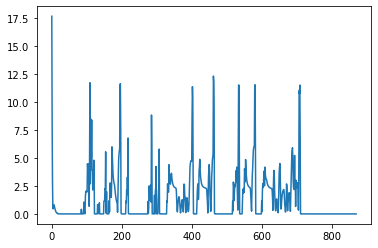

In [10]:
plt.plot(np.arange(data.shape[0]), data)
plt.show()
plt.savefig()

In [36]:
1e-10

1e-10

In [35]:
def angle_between_vectors(vector1, vector2):
    # 计算两个向量的夹角（弧度）
    angle_rad = np.arccos(np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2)))

    # 将弧度转换为角度
    angle_deg = np.degrees(angle_rad)

    # 判断夹角范围并输出结果
    if 90 <= angle_deg <= 270:
        return -1
    else:
        return 1

def plot_vectors(vector1, vector2):
    # 创建一个图形
    fig, ax = plt.subplots()

    # 画出原点
    ax.quiver(0, 0, 0, 0, angles='xy', scale_units='xy', scale=1, color='gray', alpha=0.5)

    # 画出第一个向量
    ax.quiver(0, 0, vector1[0], vector1[1], angles='xy', scale_units='xy', scale=1, color='blue', label='Vector A')

    # 画出第二个向量
    ax.quiver(0, 0, vector2[0], vector2[1], angles='xy', scale_units='xy', scale=1, color='red', label='Vector B')

    # 设置图形属性
    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_aspect('equal', adjustable='box')
    ax.legend()

    # 显示图形
    plt.show()

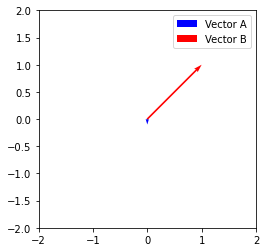

-1

In [34]:
v1 = np.array([0, -0.1])
v2 = np.array([1, 1])
plot_vectors(v1, v2)
angle_between_vectors(v1, v2)

1

In [ ]:
Vector3D(x=-0.001884, y=0.331141, z=0.002897)
Vector3D(x=0.003834, y=2.908148, z=0.040493)
